<a href="https://colab.research.google.com/github/theFulminatedHuman/DCGAN-implementation-on-CelebA-dataset/blob/main/DCGAN_on_Celeb_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pwd

/content


In [ ]:
!wget https://www.kaggle.com/datasets/jessicali9530/celeba-dataset

--2024-06-15 19:32:44--  https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘celeba-dataset’

celeba-dataset          [ <=>                ]  12.10K  --.-KB/s    in 0s      

2024-06-15 19:32:44 (92.7 MB/s) - ‘celeba-dataset’ saved [12394]



In [1]:
!pip install kaggle

In [2]:
!kaggle datasets download -d jessicali9530/celeba-dataset


Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other
100% 1.33G/1.33G [00:27<00:00, 46.1MB/s]
100% 1.33G/1.33G [00:27<00:00, 52.6MB/s]


In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time

from IPython import display

In [4]:
!unzip celeba-dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [56]:
all_image_path = []
full_image_train_path = '/content/img_align_celeba/img_align_celeba'
for path in os.listdir(full_image_train_path):
  if '.jpg' in path:
    all_image_path.append(os.path.join(full_image_train_path, path))
image_path_50k = all_image_path[0:30000]
len(image_path_50k)

30000

In [57]:
from PIL import Image
training_images = [np.array((Image.open(path)).resize((64,64))) for path in image_path_50k]

In [58]:
for i in range(len(training_images)):
  training_images[i] = tf.cast(training_images[i], tf.float32)
  training_images[i] = (training_images[i] / 127.5) - 1.0
  #training_images[i] = ((training_images[i] - training_images[i].min())/(255 - training_images[i].min()))

training_images = np.array(training_images)

In [59]:
buffer_size = 30000
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices(training_images).shuffle(buffer_size).batch(batch_size)

In [60]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 512)))
    assert model.output_shape == (None, 8, 8, 512)

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

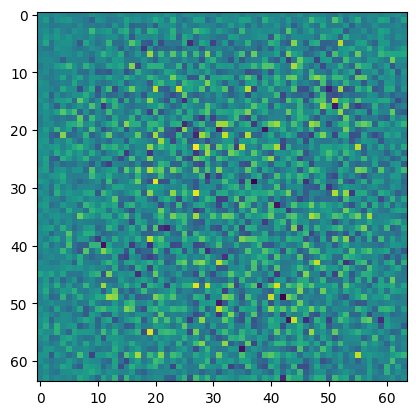

In [61]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [62]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [63]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00023194]], shape=(1, 1), dtype=float32)


In [64]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [65]:
def discloss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    totaloss = real_loss + fake_loss
    return totaloss

In [66]:
def genloss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [67]:
genoptimizer = tf.keras.optimizers.Adam(5e-4)
discoptimizer = tf.keras.optimizers.Adam(5e-4)

In [68]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=genoptimizer,
                                 discriminator_optimizer=discoptimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [69]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 10
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [75]:
gen_loss_history = []
disc_loss_history = []
combined_loss_history = []
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = genloss(fake_output)
      disc_loss = discloss(real_output, fake_output)
      total_loss = gen_loss + disc_loss

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    genoptimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discoptimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss, total_loss

In [76]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    gen_loss_epoch = []
    disc_loss_epoch = []
    total_loss_epoch = []

    for image_batch in dataset:
      gen_loss, disc_loss, total_loss = train_step(image_batch)
      gen_loss_epoch.append(gen_loss)
      disc_loss_epoch.append(disc_loss)
      total_loss_epoch.append(total_loss)

    gen_loss_history.append(np.mean(gen_loss_epoch))
    disc_loss_history.append(np.mean(disc_loss_epoch))
    combined_loss_history.append(np.mean(total_loss_epoch))

    print(f'Epoch {epoch + 1}, Gen Loss: {gen_loss_history[-1]}, Disc Loss: {disc_loss_history[-1]}, Total Loss: {combined_loss_history[-1]}')
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    plot_losses(gen_loss_history, disc_loss_history, combined_loss_history)

  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [77]:
def plot_losses(gen_losses, disc_losses, combined_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.plot(combined_losses, label='Combined Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

In [78]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4, 4))
  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow(predictions[i].numpy().reshape(64, 64, 3))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)